# 패키지 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import os
import json

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
# Show length
print(len(index_inputs),  len(index_outputs), len(index_targets))

20 20 20


# 모델 만들기에 필요한 값 선언

In [7]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

# 모델

## 인코더

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        # Gated Recurrent Unit의 약자로, 순환 신경망(RNN) 계열의 인공 신경망에서 사용되는 한 종류입니다. 
        # GRU는 LSTM(Long Short-Term Memory)과 함께, RNN의 한계를 극복하기 위해 제안된 알고리즘입니다.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

## 어텐션

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 디코더

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [11]:
# 최적화 알고리즘으로 Adam을 사용하도록 설정
optimizer = tf.keras.optimizers.Adam()

# 손실 함수로 Sparse Categorical Crossentropy를 사용하며,
# 이 함수는 정답 레이블이 one-hot 인코딩이 아닌 정수 형태로 주어질 때 사용
# from_logits=True는 로짓(logit) 출력이 주어질 때 사용하며,
# reduction="None"은 각 샘플별 손실을 반환함을 의미
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


# 학습 정확도를 측정하기 위해 Sparse Categorical Crossentropy 메트릭을 사용
# name='accuracy'는 이 메트릭의 이름을 'accuracy'로 지정
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# 손실값을 계산하는 사용자 정의 함수
def loss(real, pred):
    # real 값이 0인 부분(보통 패딩된 부분)을 찾아내기 위한 마스크 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 손실값 계산 (real: 실제값, pred: 예측값)
    loss_ = loss_object(real, pred)
    # 마스크를 loss와 같은 데이터 타입으로 변환
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 마스크를 손실값에 곱하여, 마스크된 부분(패딩된 부분)은 손실값에서 제외
    loss_ *= mask
    # 전체 손실값의 평균을 계산하여 반환
    return tf.reduce_mean(loss_)    

# 정확도를 계산하는 사용자 정의 함수
def accuracy(real, pred):
    # real 값이 0인 부분(보통 패딩된 부분)을 찾아내기 위한 마스크 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 마스크를 pred와 같은 데이터 타입으로 변환하고, 차원을 확장
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    # 마스크를 pred에 곱하여, 마스크된 부분(패딩된 부분)은 정확도 계산에서 제외
    pred *= mask    
    # 마스크된 부분을 제외한 정확도를 계산
    acc = train_accuracy(real, pred)
    # 전체 정확도의 평균을 계산하여 반환
    return tf.reduce_mean(acc)


## 시퀸스 투 시퀸스 모델

In [12]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx  # 디코딩 종료를 위한 토큰 인덱스
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)  # 인코더 초기화
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)  # 디코더 초기화

    def call(self, x):
        inp, tar = x  # 입력 (source sentence)과 타겟 (target sentence)을 분리

        enc_hidden = self.encoder.initialize_hidden_state(inp)  # 인코더의 초기 은닉 상태 초기화
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)  # 인코더를 통해 입력을 처리

        dec_hidden = enc_hidden  # 인코더의 최종 은닉 상태를 디코더의 초기 은닉 상태로 설정

        predict_tokens = list()  # 예측된 토큰들을 저장할 리스트
        for t in range(0, tar.shape[1]):  # 타겟 시퀀스의 길이만큼 반복
            # 현재 타임스텝의 타겟 토큰을 디코더 입력으로 사용
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32)  
            # 디코더를 통해 예측된 토큰, 새로운 디코더 은닉 상태 및 어텐션 가중치를 계산
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            # 예측된 토큰을 리스트에 추가
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        # 예측된 토큰들을 스택하여 반환 (모든 타임스텝에 대한 예측 결과)
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp = x  # 입력 (source sentence)

        enc_hidden = self.encoder.initialize_hidden_state(inp)  # 인코더의 초기 은닉 상태 초기화
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)  # 인코더를 통해 입력을 처리

        dec_hidden = enc_hidden  # 인코더의 최종 은닉 상태를 디코더의 초기 은닉 상태로 설정
        
        # 디코더의 첫 입력을 <SOS> (Start Of Sentence) 토큰으로 설정
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()  # 예측된 토큰들을 저장할 리스트
        for t in range(0, MAX_SEQUENCE):  # 최대 시퀀스 길이만큼 반복
            # 디코더를 통해 예측된 토큰, 새로운 디코더 은닉 상태 및 어텐션 가중치를 계산
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            # 예측된 토큰의 인덱스를 가져옴
            predict_token = tf.argmax(predictions[0])
            
            # 예측된 토큰이 종료 토큰일 경우 반복 종료
            if predict_token == self.end_token_idx:
                break
            
            # 예측된 토큰을 리스트에 추가
            predict_tokens.append(predict_token)
            # 예측된 토큰을 다음 디코더 입력으로 설정
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        # 예측된 토큰들을 스택하여 반환 (최종 예측된 시퀀스)
        return tf.stack(predict_tokens, axis=0).numpy()


In [13]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

## 학습 진행

In [14]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '.weights.h5'

# callback 함수 생성
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, mode= 'max')

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8149 - loss: 0.8883
Epoch 1: val_accuracy improved from -inf to 0.85400, saving model to ./data_out/seq2seq_kor.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 718ms/step - accuracy: 0.8170 - loss: 0.8837 - val_accuracy: 0.8540 - val_loss: 0.6887
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8520 - loss: 0.8026
Epoch 2: val_accuracy improved from 0.85400 to 0.85600, saving model to ./data_out/seq2seq_kor.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.8522 - loss: 0.7968 - val_accuracy: 0.8560 - val_loss: 0.6163
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8547 - loss: 0.7281
Epoch 3: val_accuracy improved from 0.85600 to 0.85667, saving model to ./data_out/seq2seq_kor.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - accuracy: 0.8548 - loss: 0.7224 - val_accuracy: 0.8567 - val_loss: 0.6108
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8558 - loss: 0.7058
Epo

# 결과 플롯

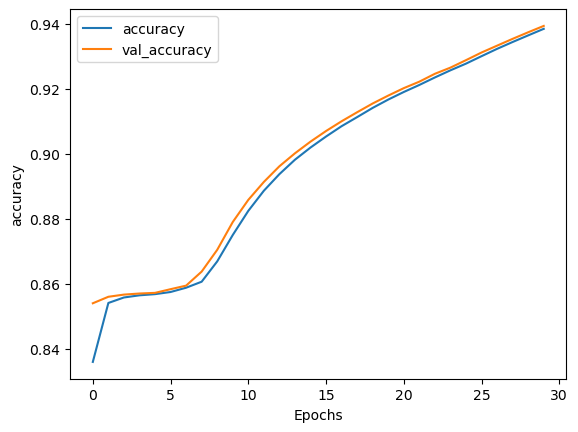

In [15]:
plot_graphs(history, 'accuracy')

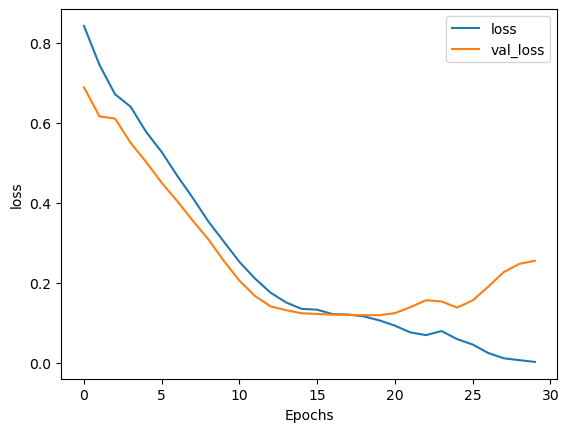

In [16]:
plot_graphs(history, 'loss')

## 결과 확인

In [17]:
# model.load_weights('./data_out/seq2seq_kor.weights.h5')

In [36]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], char2idx)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[66 98 31 42 65 88]
평소에 필요했던 게 좋을 것 같아요
